### Simple 2D exampling of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from diffusion import (
    get_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_2d,
)
from util import (
    get_torch_size_string,
    plot_ddpm_2d_result,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.3.0].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
device = 'cpu' # mps, cpu
print ("device:[%s]"%(device))

device:[cpu]


### Training data `x_0`: [N x C x W x H]

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
x_0 = train_data[:,None,:,:].to(device)/255.
print ("MNIST ready. train_data:[%s]"%(get_torch_size_string(x_0)))

MNIST ready. train_data:[60000x1x28x28]


### Train 

In [4]:
# Instantiate U-net
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 2,
    n_in_channels        = 1,
    n_base_channels      = 64,
    n_emb_dim            = 128,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False, # no attention for images
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,1,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x W x H] => output:[B x C x W x H]

# Configuration
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x W x H]
    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x W x H]
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)

print ("Done.")

KeyboardInterrupt: 

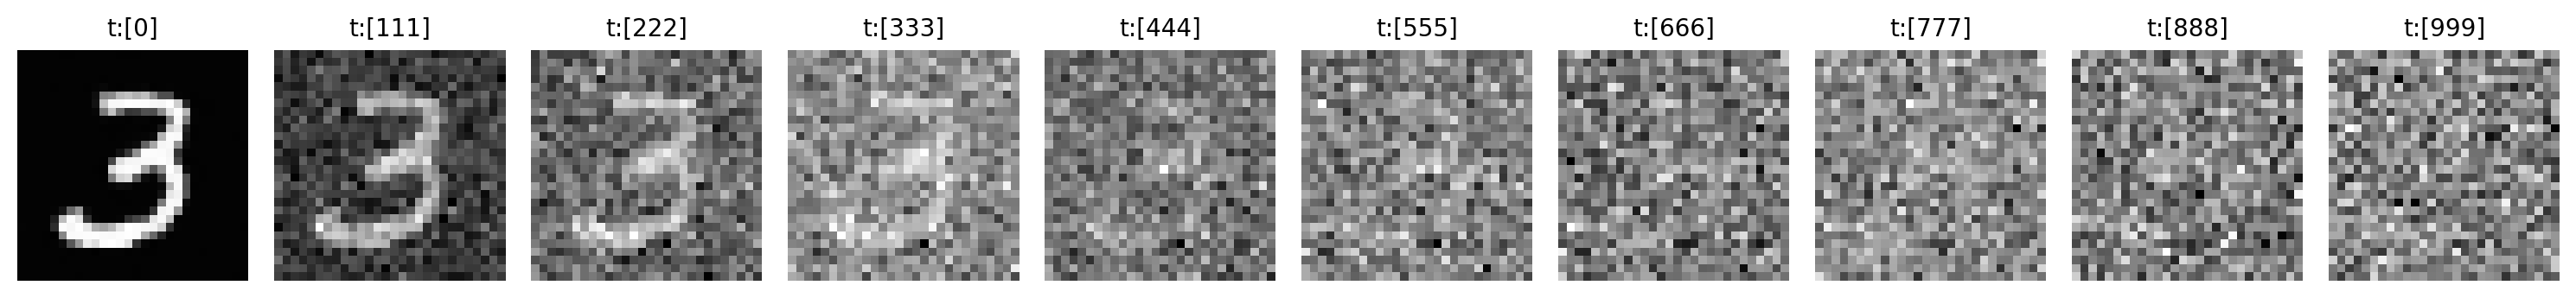

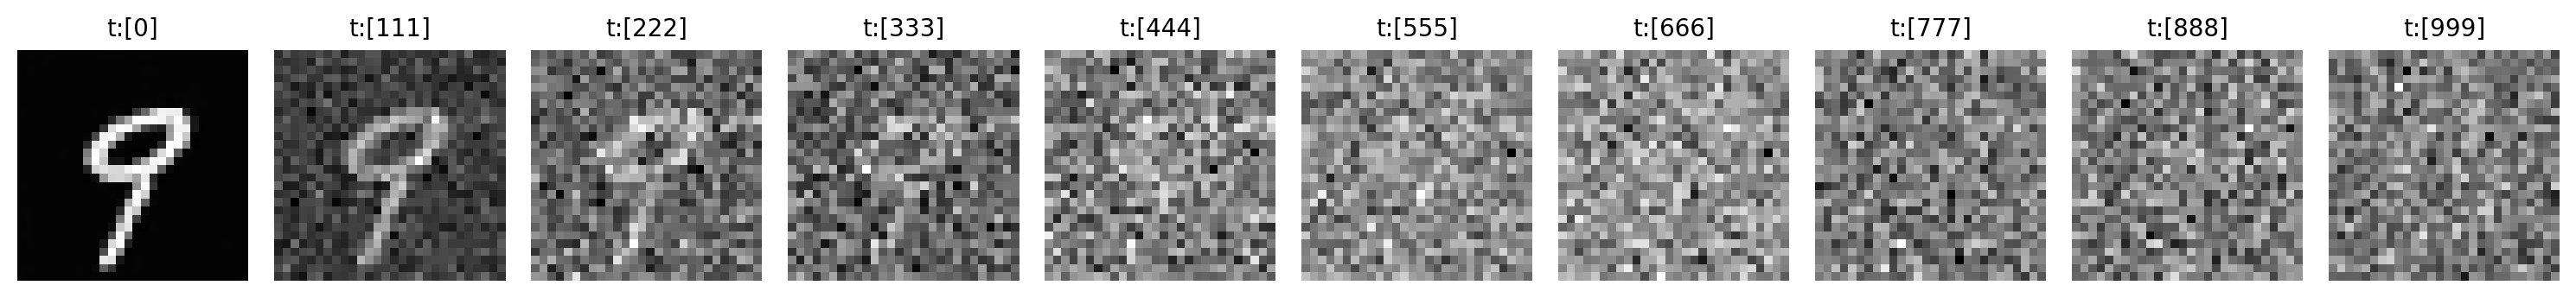

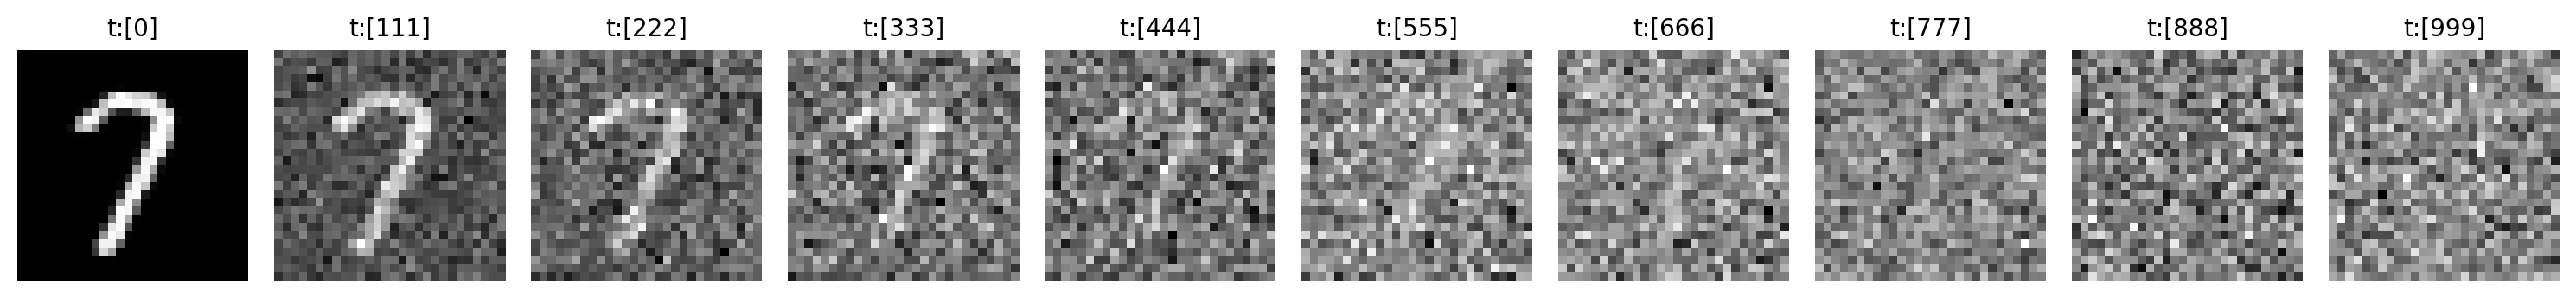

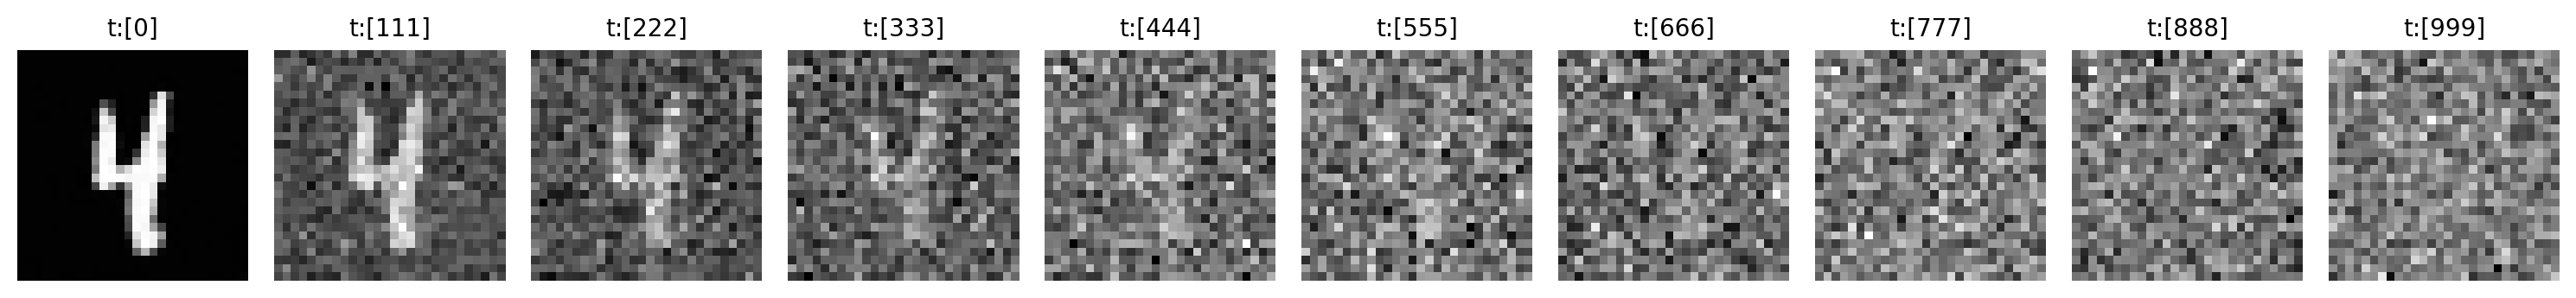

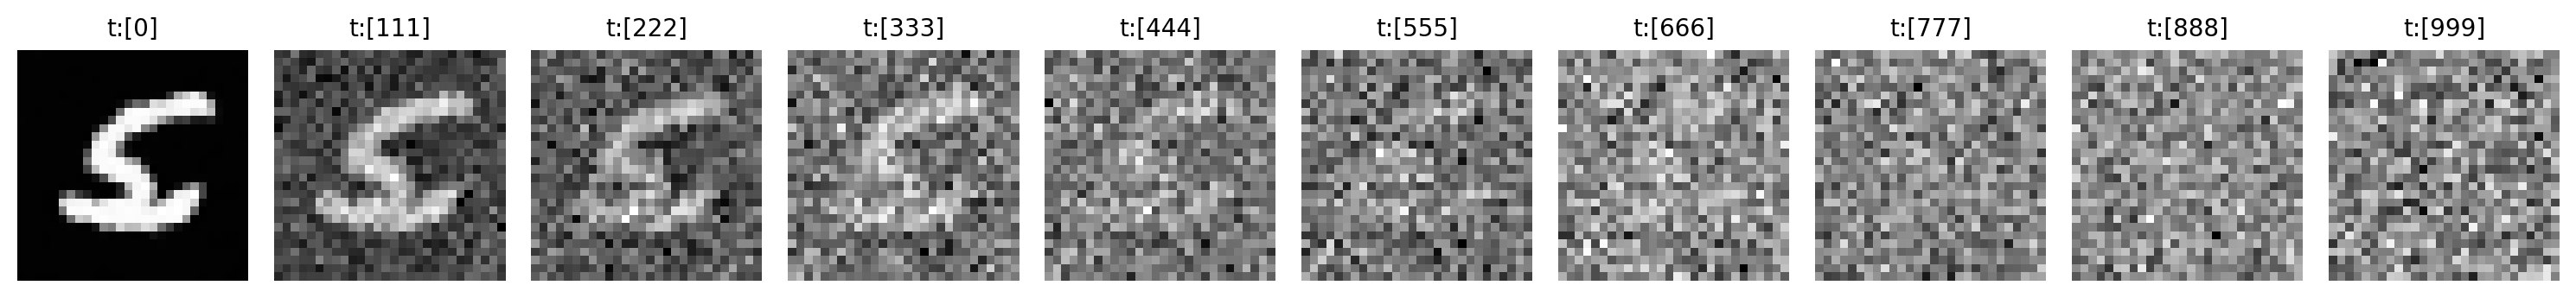

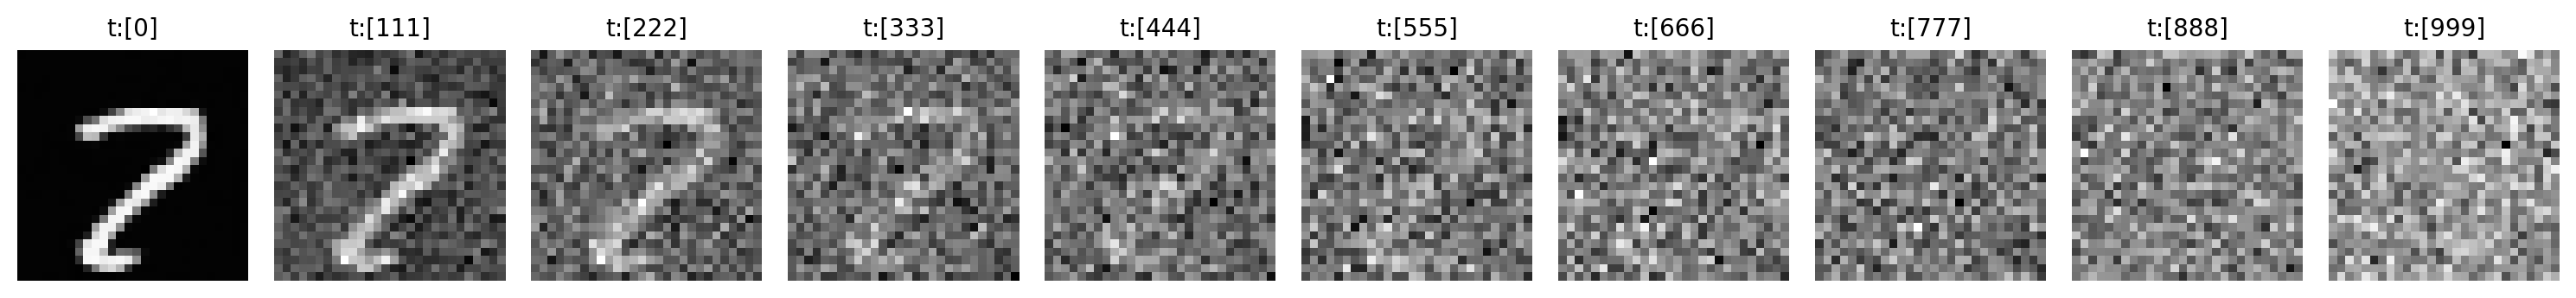

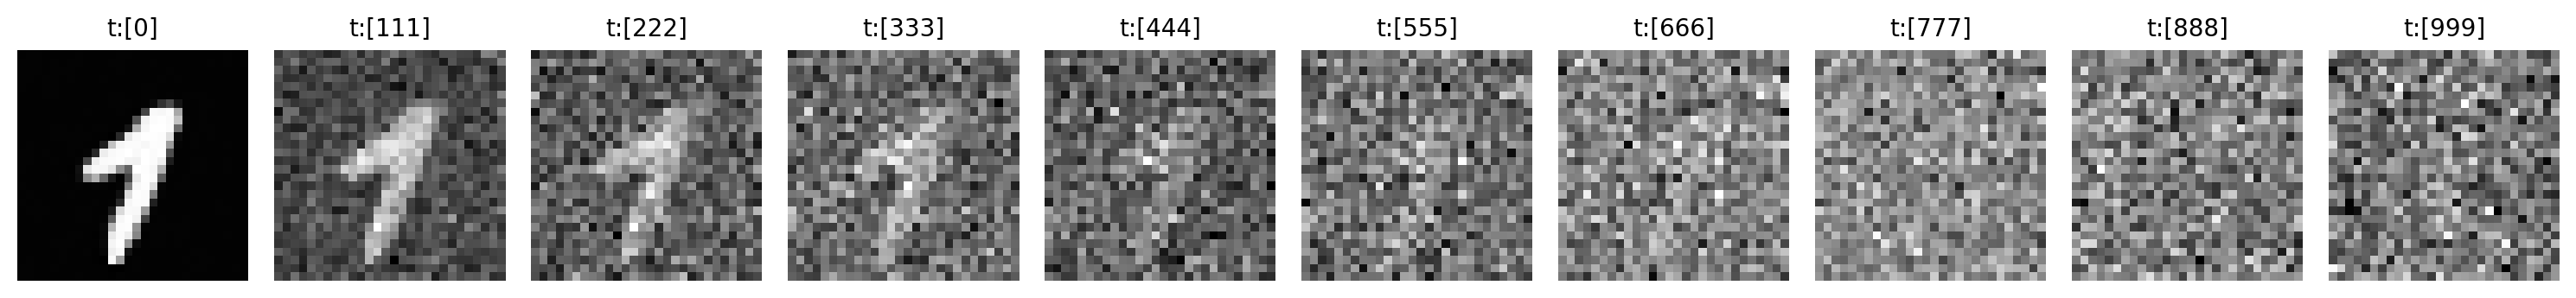

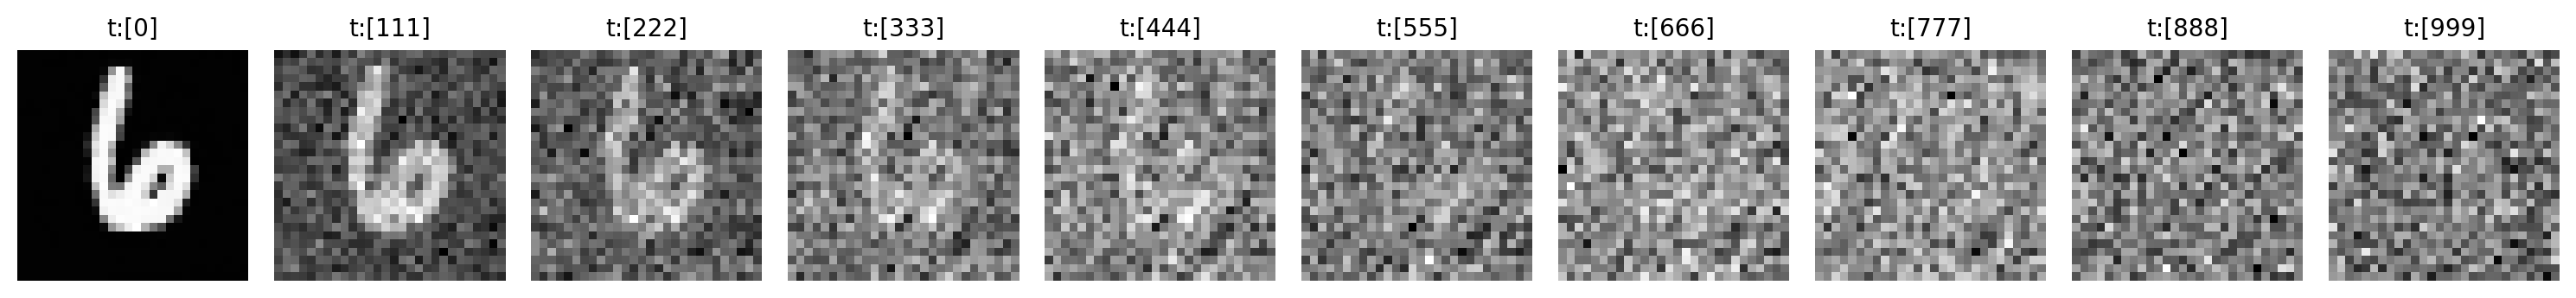

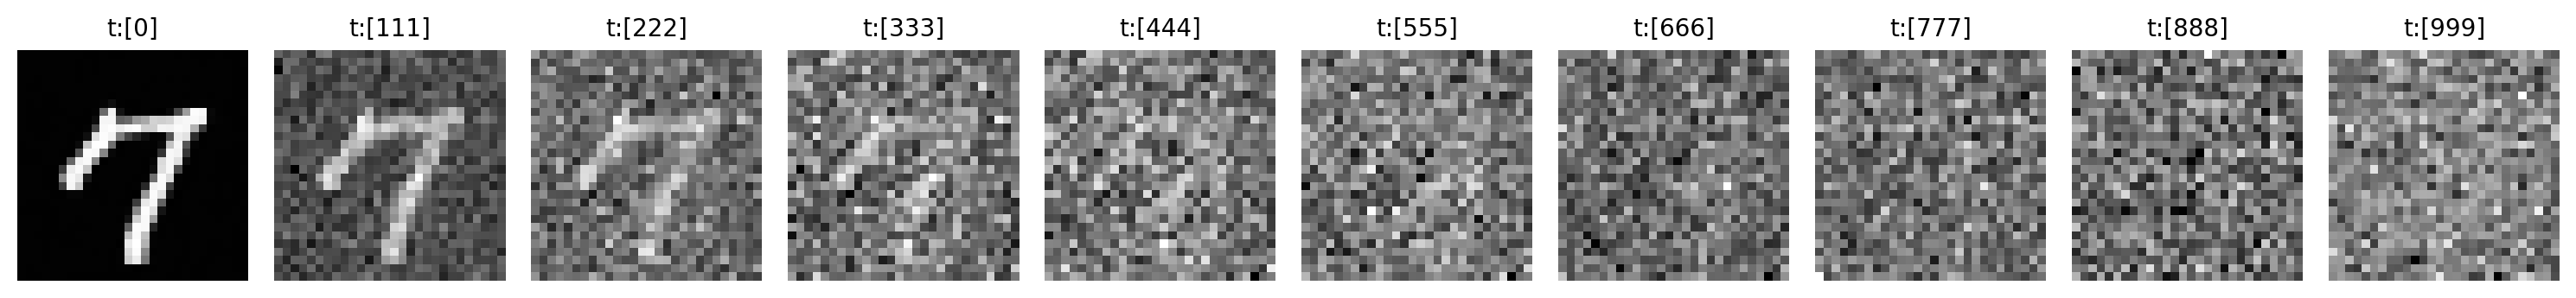

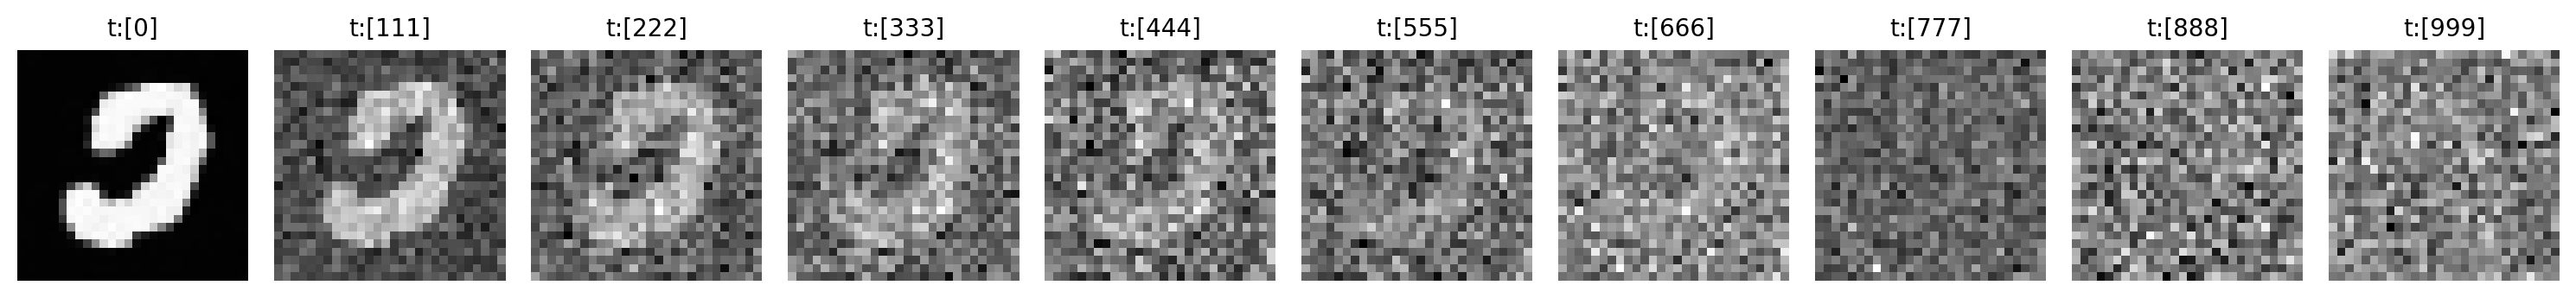

In [5]:
n_sample = 10
step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device)
plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

In [21]:
import torch
import torch.nn as nn

# Define the unique labels
labels = torch.tensor([[1, 1], [1, 0]])

# Create a dictionary to map labels to unique indices
label_to_index = {tuple(label.tolist()): idx for idx, label in enumerate(labels)}

# Convert the labels to indices
indices = torch.tensor([label_to_index[tuple(label.tolist())] for label in labels])

# Define the embedding layer
embedding_dim = 128  # Desired dimension to expand to
num_labels = len(label_to_index)
embedding_layer = nn.Embedding(num_labels, embedding_dim)

# Get the positional encoding vectors
positional_encodings = embedding_layer(indices)

print("Label to Index Mapping:", label_to_index)
print("Indices:", indices)
print("Positional Encodings:", positional_encodings)

Label to Index Mapping: {(1, 1): 0, (1, 0): 1}
Indices: tensor([0, 1])
Positional Encodings: tensor([[ 5.2498e-01, -4.8471e-01, -4.6111e-01,  7.3475e-01, -1.3067e+00,
         -1.0054e+00, -2.3522e-01, -2.2189e-01, -9.0135e-01, -7.8224e-01,
          3.4895e-01, -1.0981e-01,  3.9596e-02,  1.7469e+00,  1.0769e-01,
          3.3730e-01,  1.1674e+00, -1.8714e-01, -6.2842e-01,  1.3255e+00,
         -6.3334e-02, -1.3978e+00,  4.1444e-01, -9.3154e-01,  2.4039e+00,
         -3.3955e-01, -2.1937e+00,  6.8547e-01, -4.8166e-01, -2.6725e-02,
         -1.0845e+00, -9.0124e-01,  7.2271e-01,  7.6349e-01, -1.5417e-01,
         -1.0081e+00, -1.0471e+00,  1.8057e+00, -1.3018e+00, -6.4903e-01,
         -2.4313e-02, -6.8244e-01,  1.8332e-01,  7.1703e-01, -1.5094e-01,
         -2.2122e-01,  7.6954e-01,  3.0001e-02,  1.6518e+00, -1.8509e-01,
         -3.4281e-01,  3.3363e-01,  9.6231e-01, -7.9001e-01,  9.8148e-01,
          1.0147e+00,  7.1631e-01, -1.1591e+00,  5.4528e-01,  5.0131e-01,
          2.4148e+0

In [22]:
example_label = torch.tensor([0, 0])
print(embedding_layer(example_label))
example_label = torch.tensor([0, 1])
print(embedding_layer(example_label))
example_label = torch.tensor([1, 0])
print(embedding_layer(example_label))
example_label = torch.tensor([1, 1])
print(embedding_layer(example_label))


tensor([[ 0.5250, -0.4847, -0.4611,  0.7347, -1.3067, -1.0054, -0.2352, -0.2219,
         -0.9014, -0.7822,  0.3489, -0.1098,  0.0396,  1.7469,  0.1077,  0.3373,
          1.1674, -0.1871, -0.6284,  1.3255, -0.0633, -1.3978,  0.4144, -0.9315,
          2.4039, -0.3396, -2.1937,  0.6855, -0.4817, -0.0267, -1.0845, -0.9012,
          0.7227,  0.7635, -0.1542, -1.0081, -1.0471,  1.8057, -1.3018, -0.6490,
         -0.0243, -0.6824,  0.1833,  0.7170, -0.1509, -0.2212,  0.7695,  0.0300,
          1.6518, -0.1851, -0.3428,  0.3336,  0.9623, -0.7900,  0.9815,  1.0147,
          0.7163, -1.1591,  0.5453,  0.5013,  2.4148,  0.1431, -1.0310, -1.8969,
          1.7854, -0.6986,  1.9490, -0.1698,  0.5889,  0.5340,  0.5815, -0.8624,
          1.2045, -1.0097,  0.0446, -2.0506, -0.5824,  1.0351, -0.0259,  0.7393,
         -0.5889, -0.2907,  1.5972,  2.5240, -0.3378,  0.9787, -0.4834,  0.4066,
          0.8566,  0.3205, -1.2546, -2.5446, -0.1918, -0.4774,  0.7829,  0.4965,
          0.2921,  0.8865, -

In [24]:
import torch
import torch.nn as nn
from itertools import product

# Define the length of the label vector
label_length = 4

# Generate all possible binary vectors of the given length
labels = torch.tensor(list(product([0, 1], repeat=label_length)))

# Create a dictionary to map labels to unique indices
label_to_index = {tuple(label.tolist()): idx for idx, label in enumerate(labels)}

# Define the embedding layer
embedding_dim = 8  # Desired dimension to expand to
num_labels = len(label_to_index)
embedding_layer = nn.Embedding(num_labels, embedding_dim)

# Initialize the embedding layer with some values
embedding_layer.weight.data = torch.randn(num_labels, embedding_dim)

# Function to get the embedding vector for a given label
def get_embedding_vector(label):
    index = torch.tensor(label_to_index[tuple(label.tolist())])
    return embedding_layer(index).detach()

# Example usage
example_label = torch.tensor([1, 0, 0, 0])  # Example label to query
embedding_vector = get_embedding_vector(example_label)

print(f"Label: {example_label}")
print(f"Embedding Vector: {embedding_vector}")

Label: tensor([1, 0, 0, 0])
Embedding Vector: tensor([ 0.2269, -1.5439, -0.8169,  0.2507,  0.8996, -0.5453,  0.0125,  0.2375])


In [27]:

# Example usage
example_label = torch.tensor([0, 0, 0, 0])  # Example label to query
embedding_vector = get_embedding_vector(example_label)

print(f"Label: {example_label}")
print(f"Embedding Vector: {embedding_vector}")

Label: tensor([0, 0, 0, 0])
Embedding Vector: tensor([-0.4000,  1.9595, -0.8556,  0.0124, -1.1963, -0.3128, -0.1707,  1.2393])
